In [1]:
import pandas as pd
import sys
sys.path.insert(0, './Libs/Training/')
import trainingUtils as TU
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [2]:
Xlearn = pd.read_csv("./Data/PreprocessingOutput/Xlearn.csv", header = 0).values
ylearn = pd.read_csv("./Data/PreprocessingOutput/ylearn.csv", header = 0).values

def linearRegressionTrain(Xlearn, ylearn, tscv):
    performance = pd.DataFrame(columns=["Train Index", "MAE train", "MSE train", 
        "R2 train", "MAE test", "MSE test", "R2 test"])
    for trainIndex, Xtrain, ytrain, Xtest, ytest in TU._getTrainingData(Xlearn, ylearn, tscv):
        model, polymodel = TU._linearRegressionTrain(Xtrain, ytrain)
        maeTrain, mseTrain, r2Train = TU._performance(ytrain, model.predict(polymodel.transform(Xtrain)))
        maeTest, mseTest, r2Test = TU._performance(ytest, model.predict(polymodel.transform(Xtest)))
        performance.loc[len(performance)] = [trainIndex, maeTrain, mseTrain, r2Train, maeTest, mseTest, r2Test]
    return performance

tscv = TimeSeriesSplit(n_splits = 3)
result = linearRegressionTrain(Xlearn, ylearn, tscv.split(Xlearn))
print(result)

   Train Index  MAE train  MSE train  R2 train    MAE test      MSE test  \
0       1749.0   0.017333   0.000519  0.261834  252.087946  3.064497e+06   
1       3499.0   0.017271   0.000526  0.149696    0.026555  1.192081e-03   
2       5249.0   0.015952   0.000485  0.100079    0.063392  8.868770e-03   

        R2 test  
0 -5.732628e+09  
1 -2.148099e+00  
2 -2.360179e+01  


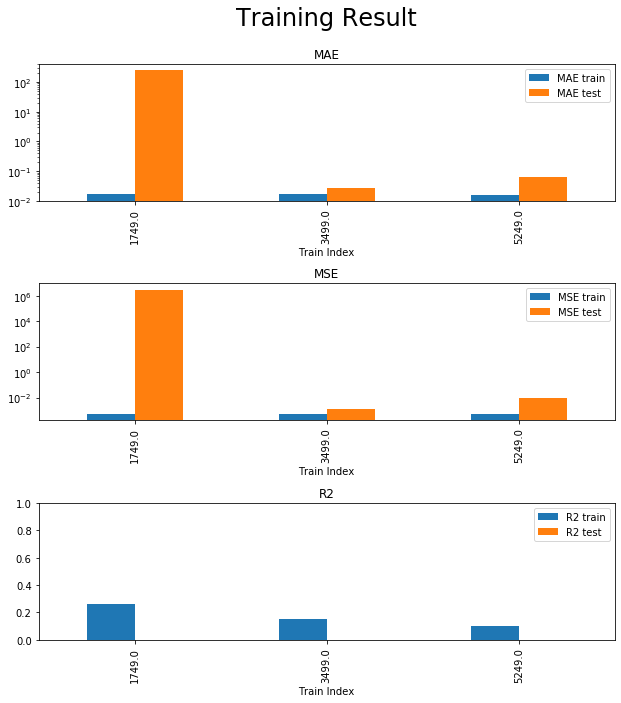

In [3]:
 TU._plotTrainResult(result)

maeTest = 0.04824757844557668, mseTest = 0.005872301880324494, r2Test = -26.96622860595502


(0.6, 1.2)

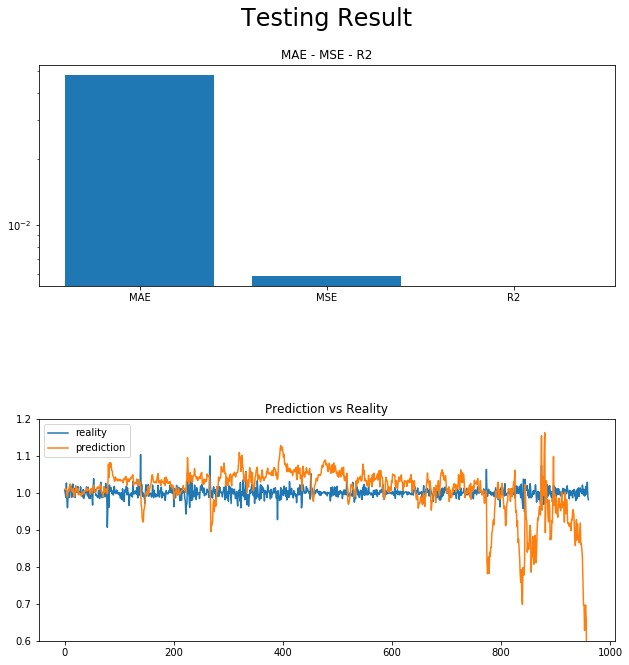

In [4]:
Xtest = pd.read_csv("./Data/PreprocessingOutput/Xtest.csv", header = 0).values
ytest = pd.read_csv("./Data/PreprocessingOutput/ytest.csv", header = 0).values

model, polymodel = TU._linearRegressionTrain(Xlearn, ylearn)
maeTest, mseTest, r2Test, ypredict = TU._predictModel(Xtest, ytest, model, polymodel)
print(f"maeTest = {maeTest}, mseTest = {mseTest}, r2Test = {r2Test}")

axes = TU._plotTestResult(maeTest, mseTest, r2Test, ytest, ypredict)
axes[1].set_ylim([0.6, 1.2])